In [1]:
#%matplotlib widget
%load_ext autoreload
%autoreload 2
import pandas as pd
import matplotlib.pyplot as plt
import os
import math

In [2]:
import importlib

In [39]:
print(os.getcwd())
import sys
sys.path.append('/Users/andreamaldonado/git_tree/perfSky/perfSky')

from Skyline import get_relative_timestamps

/Users/andreamaldonado/git_tree/perfSky/notebooks


In [40]:
from perfSky import Visualizer as pt

In [41]:
ACTIVITY_ID='common_act'

#df = pd.read_csv("../data/daily.2019-July_September.csv")
df = pd.read_csv("../data/clustered_agg_edit_75_daily.csv", sep=";")
#df = df[['case', 'activity', 'start_time', 'end_time','cluster_id']]
#df['start_time']=df['start_time'].apply(lambda x: x.split('+')[0])
#df['end_time']=df['end_time'].apply(lambda x: x.split('+')[0])
df['activity_original'] = df['activity']
df['activity']=df[ACTIVITY_ID]
df.head()

,case,activity,start_time,end_time,cluster_id,common_act,activity_original
0,daily.2019-09-24_05-05-02,DumpTask(sql_filename=_11,2019-09-24 05:20:10,2019-09-24 05:40:21,11,DumpTask(sql_filename=_11,DumpTask(sql_filename=regular_urls)(kvs=None)(...
1,daily.2019-09-24_05-05-02,DumpTask(sql_filename=reprocess_urls)(kvs=None...,2019-09-24 05:20:10,2019-09-24 05:21:03,62,DumpTask(sql_filename=reprocess_urls)(kvs=None...,DumpTask(sql_filename=reprocess_urls)(kvs=None...
2,daily.2019-09-24_05-05-02,DumpTask(sql_filename=_11,2019-09-24 05:20:10,2019-09-24 05:21:32,11,DumpTask(sql_filename=_11,DumpTask(sql_filename=daily_urls)(kvs=None)(ch...
3,daily.2019-09-24_05-05-02,ProxySetupTask_16,2019-09-24 05:20:10,2019-09-24 05:32:45,16,ProxySetupTask_16,ProxySetupTask
4,daily.2019-09-24_05-05-02,CrawlFeedTask_61,2019-09-24 05:20:10,2019-09-24 05:43:43,61,CrawlFeedTask_61,CrawlFeedTask


In [42]:
excluding = get_relative_timestamps(df, ['AllTasks']) #'AllTasks' is one entry per log with its overall duration


print('Data set contains:')
print('- ',len(excluding),'events')
print('- ',len(excluding['case'].unique()),'cases')
print('- ',len(excluding['activity'].unique()),'activities')
#print('- ',len(excluding['cluster_id'].unique()),' clustered activities')



Grouped: 61864 columns ['case', 'activity', 'start_time', 'end_time', 'cluster_id', 'common_act', 'activity_original', 'zero_point']
Merged relatived: 61930 columns ['case', 'activity', 'start_time', 'end_time', 'cluster_id_x', 'common_act_x', 'activity_original_x', 'zero_point', 'cluster_id_y', 'common_act_y', 'activity_original_y']
Data set contains:
-  61930 events
-  50 cases
-  75 activities


In [43]:
#print(excluding['case'].unique())
to_plot = excluding[excluding['case'].isin(['daily.2019-07-01_10-28-01','daily.2019-07-03_00-21-01'])]

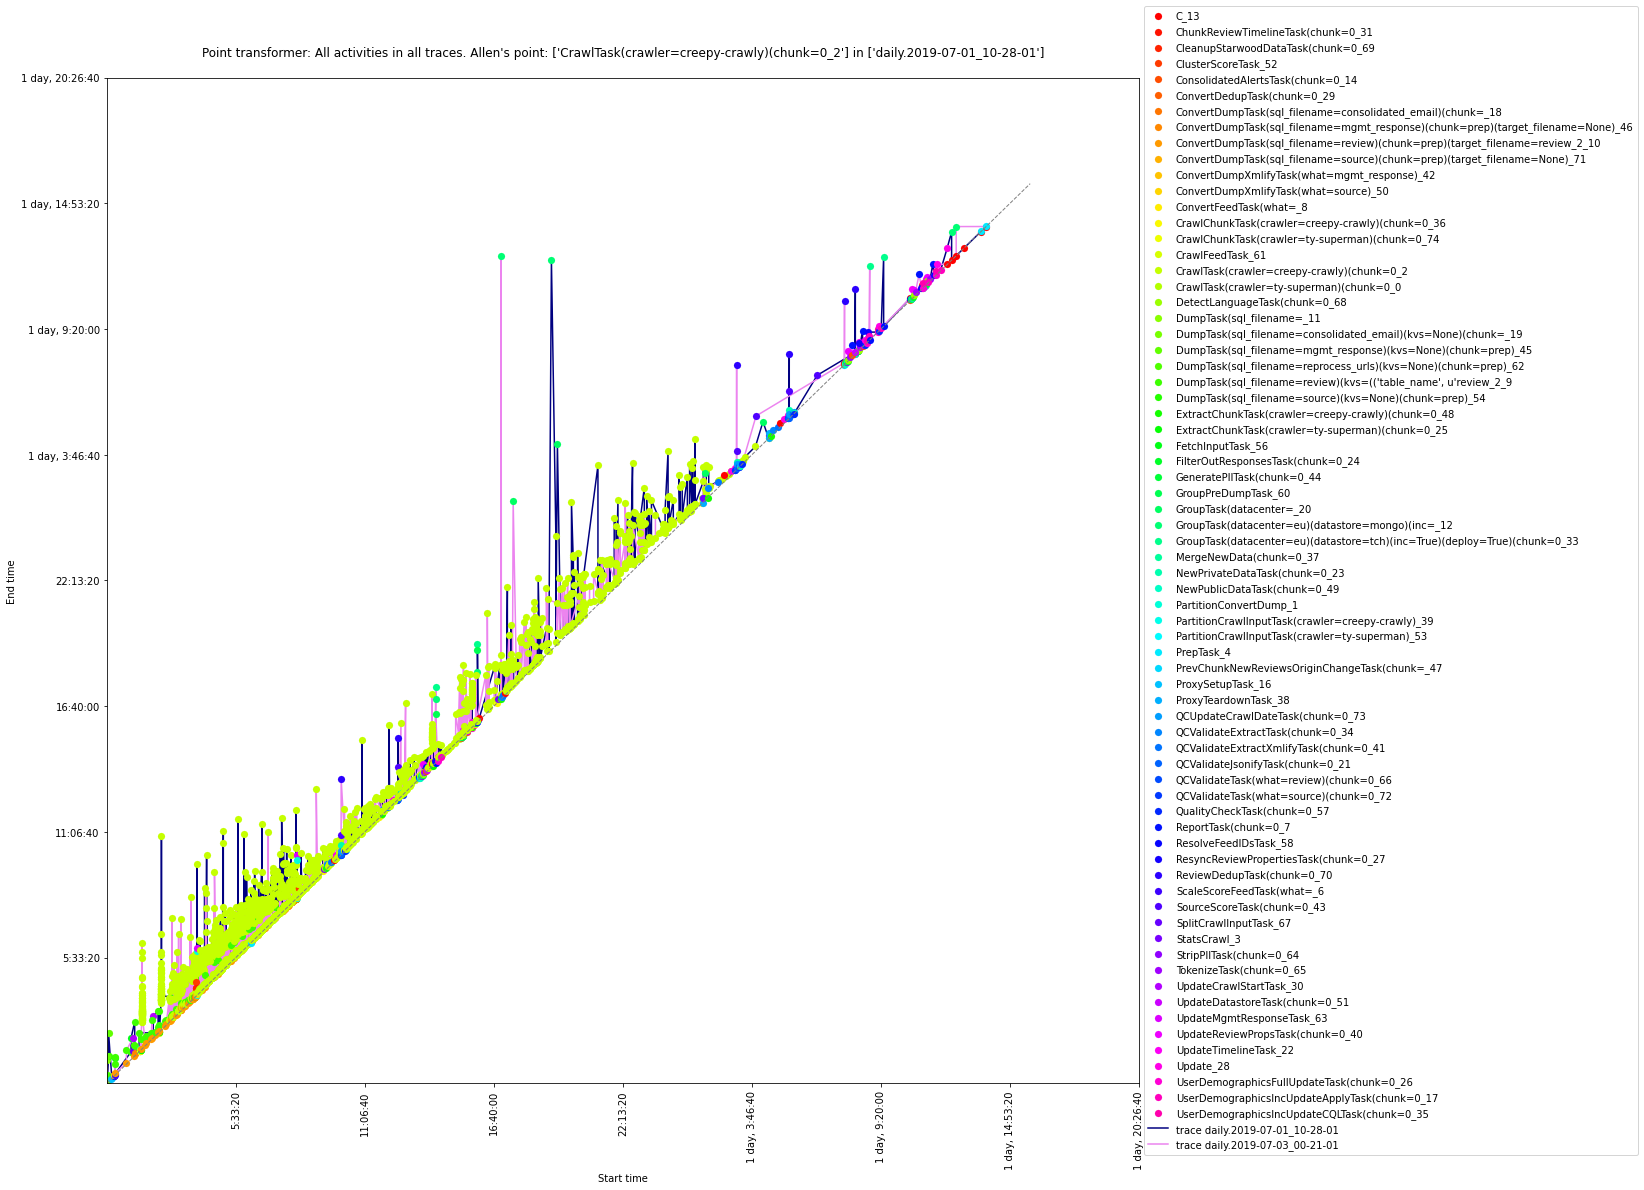

In [44]:
vis = pt.Vis()
vis.plot_all_traces(to_plot, show_plot=None)

In [45]:
average_trace_activities = vis.get_data_selection_avgtrace(vis.get_relative_timestamps(excluding)).sort_values(by=['num_start'])
print('Average trace over activities has',len(average_trace_activities),'events')
average_trace_activities.head()
#print('AllTasks' in average_trace_activities)

AttributeError: 'Vis' object has no attribute 'get_relative_timestamps'

In [ ]:
vis.plot_all_traces(average_trace_activities, show_plot=None)

In [ ]:
subset = excluding

skyline_points = vis.get_skyline_points(subset)
representative = skyline_points[['case','activity']].drop_duplicates()

print(len(subset),' points in total distributed among', len(subset['case'].unique()), 'cases\n\nInfo about the skyline:')
print('- ',len(skyline_points),'/',len(subset),'=', round(len(skyline_points)/len(subset)*100,2), '% events are part of a skyline')
print('- ',len(skyline_points['activity'].unique()),'/',len(subset['activity'].unique()),'=', round(len(skyline_points['activity'].unique())/len(subset['activity'].unique())*100,2), 'activities are part of a skyline.')
print('- ',len(representative),'/',len(skyline_points),'=', round(len(representative)/len(skyline_points)*100,2), '% unique activities on the skylines.') 
print("   'Unique' meaning there are no two points with the same 'activity' on the skyline of the same trace. ")

skyline_points.head()

In [ ]:
vis.plot_all_traces(skyline_points, show_plot=None)

# Anomaly Detection

In [92]:
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
import numpy as np 
from matplotlib.ticker import FuncFormatter


In [93]:
def plot_star_from_point(s_plot, reference_points, body_points, anomaly_name=None):
    missing_label = ['present','missing']
    #unique_trace = data_selection['case'].unique().tolist()
    colorlist = ["green", "red"]
    by_missing = dict(zip(missing_label, colorlist)) 

    axis = s_plot.get_axes()
    average_skyline = reference_points
    
    if anomaly_name == 'skyline_points_in_case':
            average_skyline = vis.get_skyline_points(reference_points)
  
    if anomaly_name == 'activity_set':
        average_skyline = body_points
        body_points = reference_points

    axis[0].plot(body_points['num_start'],body_points['num_end'],color='orange',linewidth=1.5)    
    axis[0].plot(average_skyline['num_start'],average_skyline['num_end'],color='green',linewidth=1.5)
        
    missing = average_skyline[~average_skyline['activity'].isin(body_points['activity'].unique())]
    
    for index, reference_point in missing.iterrows(): 
        x = []
        y = []
        x.append(reference_point['num_start'])
        y.append(reference_point['num_end'])
        axis[0].plot(x,y, label = 'missing', marker='s', color='red', markersize=8)
     

    if anomaly_name in ['skyline_points_in_case','activity_set']:
        for index, reference_point in reference_points.iterrows(): 
            for jndex, point in body_points[body_points['activity']==reference_point['activity']].iterrows():
                x = []
                y = []
                x.append(reference_point['num_start'])
                x.append(point['num_start'])
                y.append(reference_point['num_end'])
                y.append(point['num_end'])
                axis[0].plot(x,y,color='black', linewidth=0.5)
            
        

    handles, labels = axis[0].get_legend_handles_labels()
    expectation = mlines.Line2D([], [], color='green', marker='_', markersize=15, label='Average Trace')
    anomaly = mlines.Line2D([], [], color='orange', marker='_',markersize=15, label='Anomaly Trace')
    missing_legend = mlines.Line2D([], [], color='red', marker='s',markersize=10, label='missing activities')
    
    handles_all = list(dict.fromkeys(handles))
    axis[0].legend(handles=[expectation, anomaly, missing_legend])
    
    return s_plot

    
    present_legend = mlines.Line2D([], [], color='green', marker='s',markersize=10, label='present activities')
    present = reference_points[reference_points['activity'].isin(body_points['activity'].unique())]
    for index, reference_point in present.iterrows(): 
        x = []
        y = []
        x.append(reference_point['num_start'])
        y.append(reference_point['num_end'])
        axis[0].plot(x,y, label='present', marker='s', color='green')

    mutual = reference_point[reference_point['activity']==body_points['activity']]

    
    #skyline_plot.show()
    return s_plot

#plot_star_from_point(some_plot,average_trace_activities,anomaly_suspects, anomaly_name='skyline_points_in_case')

In [94]:
def millions(x, pos):
    'The two args are the value and tick position'
    return '%11.1i'% (x)+'%' 

def threshold_histogram(input_data, bucket=None, anomaly_name=None, in_percentage=None, x_axis_name=None):
    plt.rcdefaults()
    fig, ax = plt.subplots(figsize=(20, 20))

    input_data= input_data.sort_values(by=anomaly_name, ascending=False)
    # Example data
    y_values = input_data[bucket]
    y_pos = np.arange(len(y_values))
    x_values = input_data[anomaly_name]
    error = 0

    formatter = FuncFormatter(millions)

    ax.barh(y_pos, x_values, xerr=error, align='center')
    if in_percentage:
        ax.xaxis.set_major_formatter(formatter)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(y_values)
    ax.invert_yaxis()  # labels read top-to-bottom
    ax.set_xlabel(x_axis_name)
    ax.set_title(x_axis_name+' per '+bucket+' id')
    return plt

#threshold_histogram(merged_by_case, bucket='case', anomaly_name='skyline_percentage',in_percentage=1, x_axis_name='Percentage of events in skyline')

In [95]:
def evaluate_condition(condition, content, anomaly_name=None, bucket=None):
#    if bucket == 'activity': 
#        anomaly_results = content
    anomaly_results = content[(content[anomaly_name]<condition['lower_bound']) | (content[anomaly_name]>condition['upper_bound'])]
    return len(anomaly_results), anomaly_results[bucket].unique()
    
def get_anomaly_results(input_data, std_factors=range(10), anomaly_name=None, bucket=None):
    
    anomaly_condition = pd.DataFrame()
    anomaly_condition['factor_std'] = std_factors
    if bucket == 'activity': 
        anomaly_condition['average']=input_data.mean(axis=1).apply(math.floor)
        anomaly_condition['std']=input_data.std(axis=1)
    anomaly_condition['average'] =round(input_data[anomaly_name].mean(),2)
    anomaly_condition['std'] =round(input_data[anomaly_name].std(),2)
    anomaly_condition['lower_bound'] = anomaly_condition.apply(lambda row: round(max(row['average']-row['factor_std']*row['std'],0),2), axis=1)
    anomaly_condition['upper_bound'] = anomaly_condition.apply(lambda row: round(max(row['average']+row['factor_std']*row['std'],0),2), axis=1)
    anomaly_condition[['number_of_anomalies','anomaly_traces']] = anomaly_condition.apply(lambda row: evaluate_condition(row, input_data, anomaly_name=anomaly_name, bucket=bucket), result_type='expand', axis=1)

    return anomaly_condition

#get_anomaly_results(merged_by_case, std_factors=[ 1.5**x for x in range(16)], anomaly_name='skyline_percentage', bucket='case').head()

### Anomaly of number of points in trace: 

#### Causes for this anomaly:  
* More activities than expected being restarted. (for upper bound)
* A trace being unexpectedly interrupted. (for lower bound)
* A log being incomplete. (for lower bound)

In [97]:
threshold_events_trace = threshold_histogram(merged_by_case, bucket='case', anomaly_name='total_points_in_case', x_axis_name='Number of events in trace')
#output_path = LUIGI_LOG_PATH+'/../../graphs/allDataAtOnce/daily.2019-0709_three_months_anomaly_threshold_num_events_trace.png'
#plt.savefig(output_path,  bbox_inches='tight')

NameError: name 'merged_by_case' is not defined